Tracks under investigation:
Event 130690 trackIDs 11, 14, and 19
(from images on slide)

In [2]:
import uproot
import awkward as ak
import numpy as np
import glob
import time
from pathlib import Path
from multiprocessing import Pool
import os
from tqdm.auto import tqdm

import sys

REPO_PATH = Path.home() / "workspace/jetpointnet"
SCRIPT_PATH = REPO_PATH / "python_scripts"
sys.path.append(str(SCRIPT_PATH))


from data_processing.jets.preprocessing_header import *
from data_processing.jets.awk_utils import *
from data_processing.jets.common_utils import *

import sys
from pathlib import Path

REPO_PATH = Path.home() / "workspace/jetpointnet"
SCRIPT_PATH = REPO_PATH / "python_scripts"

sys.path.append(str(SCRIPT_PATH))


from data_processing.jets.npz_utils import (
    build_labels_array,
    build_input_array
)
from data_processing.jets.common_utils import (
    print_events,
    calculate_max_sample_length,
)
from data_processing.jets.preprocessing_header import (
    AWK_SAVE_LOC,
    INCLUDE_SETS_TO_NPZ,
    NPZ_SAVE_LOC,
    NUM_CHUNK_THREADS,
    ENERGY_SCALE,
    OVERWRITE_NPZ,
    MAX_SAMPLE_LENGTH,
)
import awkward as ak
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
import os
import time
from tqdm.auto import tqdm
from multiprocessing import Pool


In [3]:
npz_path = "/home/jhimmens/workspace/jetpointnet/pnet_data/processed_files/attempt_1_june_18/full_set/SavedNpz/deltaR=0.2_maxLen=650_sets=JZ0JZ1JZ2/energy_scale=1/val/user.mswiatlo.39955678._000258.mltree.root_chunk_0_val.parquet.npz"
awk_path = "/home/jhimmens/workspace/jetpointnet/pnet_data/processed_files/attempt_1_june_18/full_set/AwkwardArrs/deltaR=0.2/val/user.mswiatlo.39955678._000258.mltree.root_chunk_0_val.parquet"
root_path = "/fast_scratch_1/atlas/pflow/20240614/user.mswiatlo.801167.Py8EG_A14NNPDF23LO_jj_JZ2.recon.ESD.e8514_e8528_s4185_s4114_r14977_2024.06.14.1_mltree.root/user.mswiatlo.39955678._000258.mltree.root"

## Root

In [4]:
root_file = uproot.open(root_path + ":EventTree")
# index = root_file["eventNumber"].array()#.index(130690)
index_of_event = ak.where(root_file["eventNumber"].array() == 130690)[0]
"""trackEta_EMB1',
 'trackPhi_EMB1'"""
root_file.keys()

['runNumber',
 'eventNumber',
 'lumiBlock',
 'coreFlags',
 'mcEventNumber',
 'mcChannelNumber',
 'mcEventWeight',
 'nTruthPart',
 'truthPartBarcode',
 'truthPartPdgId',
 'G4PreCalo_n_EM',
 'G4PreCalo_E_EM',
 'G4PreCalo_n_Had',
 'G4PreCalo_E_Had',
 'truthVertexX',
 'truthVertexY',
 'truthVertexZ',
 'truthPartStatus',
 'truthPartPt',
 'truthPartE',
 'truthPartMass',
 'truthPartEta',
 'truthPartPhi',
 'nTrack',
 'trackPt',
 'trackP',
 'trackMass',
 'trackEta',
 'trackPhi',
 'trackTruthParticleIndex',
 'trackVisibleCalHitCaloEnergy',
 'trackFullCalHitCaloEnergy',
 'trackSubtractedCaloEnergy',
 'trackNumberOfPixelHits',
 'trackNumberOfSCTHits',
 'trackNumberOfPixelDeadSensors',
 'trackNumberOfSCTDeadSensors',
 'trackNumberOfPixelSharedHits',
 'trackNumberOfSCTSharedHits',
 'trackNumberOfPixelHoles',
 'trackNumberOfSCTHoles',
 'trackNumberOfInnermostPixelLayerHits',
 'trackNumberOfNextToInnermostPixelLayerHits',
 'trackExpectInnermostPixelLayerHit',
 'trackExpectNextToInnermostPixelLayerHit'

In [5]:
etas = root_file["trackEta_EMB1"].array()[0]
phis = root_file["trackPhi_EMB1"].array()[0]

etas[10:13], etas[13:16], etas[18:21]



(<Array [-0.309, -0.292, -1.02] type='3 * float32'>,
 <Array [-1.23, -0.325, -1e+09] type='3 * float32'>,
 <Array [-0.713, -0.197, -0.455] type='3 * float32'>)

## NPZ

In [12]:
def load_data_from_npz(npz_file):
    data = np.load(npz_file)
    feats = data['feats'][:, :MAX_SAMPLE_LENGTH]  # Shape: (num_samples, 859, 6)
    frac_labels = data['frac_labels'][:, :MAX_SAMPLE_LENGTH]  # Shape: (num_samples, 859)
    tot_labels = data['tot_labels'][:, :MAX_SAMPLE_LENGTH]  # Shape: (num_samples, 859)
    tot_truth_e = data['tot_truth_e'][:, :MAX_SAMPLE_LENGTH]  # Shape: (num_samples, 859) (This is the true total energy deposited by particles into this cell)
    return feats, frac_labels, tot_labels, tot_truth_e

feats, frac_labels, tot_labels, tot_truth_e = load_data_from_npz(npz_path)



In [13]:
num_points = 650

# 19 tracks in event 130690: list(feats["event_number"][:, 0]).count(130690)

event_array_dtype = np.dtype([ # none can be unsigned because -1 is used as a pad for all, see above
                ('event_number', np.int32),
                ('cell_ID', np.int32),
                ('track_ID', np.int32),
                ('delta_R', np.float32),             
                ('category', np.int8),
                ('track_num', np.int32),
                ('normalized_x', np.float32),
                ('normalized_y', np.float32),
                ('normalized_z', np.float32),
                ('normalized_distance', np.float32),
                ('cell_E', np.float32),
                ('track_pt', np.float32),
            ])

track_num = 13
idx_0 = 10 # trackID 2
idx_1 = 16 # trackID 11
feats["normalized_x"][track_num][feats["track_ID"][track_num] != -1][16]
feats["track_ID"][track_num][feats["track_ID"][track_num] != -1][10]

2

In [14]:
feats.shape

(2681, 650)

## Awkward

In [11]:
def read_parquet(filename):
    table = pq.read_table(filename)
    ak_array = ak.from_arrow(table)
    return ak_array

awk_arr = read_parquet(awk_path)
awk_arr

<Array [[{trackID: 0, ...}, ..., {...}], ...] type='150 * var * {trackID: i...'>

In [7]:
import uproot 
import matplotlib.pyplot as plt

file = uproot.open("/fast_scratch_1/atlas/pflow/20240614/user.mswiatlo.801165.Py8EG_A14NNPDF23LO_jj_JZ0.recon.ESD.e8514_e8528_s4185_s4114_r14977_2024.06.14.1_mltree.root/user.mswiatlo.39955613._000734.mltree.root" + ":EventTree")
file.keys()

['runNumber',
 'eventNumber',
 'lumiBlock',
 'coreFlags',
 'mcEventNumber',
 'mcChannelNumber',
 'mcEventWeight',
 'nTruthPart',
 'truthPartBarcode',
 'truthPartPdgId',
 'G4PreCalo_n_EM',
 'G4PreCalo_E_EM',
 'G4PreCalo_n_Had',
 'G4PreCalo_E_Had',
 'truthVertexX',
 'truthVertexY',
 'truthVertexZ',
 'truthPartStatus',
 'truthPartPt',
 'truthPartE',
 'truthPartMass',
 'truthPartEta',
 'truthPartPhi',
 'nTrack',
 'trackPt',
 'trackP',
 'trackMass',
 'trackEta',
 'trackPhi',
 'trackTruthParticleIndex',
 'trackVisibleCalHitCaloEnergy',
 'trackFullCalHitCaloEnergy',
 'trackSubtractedCaloEnergy',
 'trackNumberOfPixelHits',
 'trackNumberOfSCTHits',
 'trackNumberOfPixelDeadSensors',
 'trackNumberOfSCTDeadSensors',
 'trackNumberOfPixelSharedHits',
 'trackNumberOfSCTSharedHits',
 'trackNumberOfPixelHoles',
 'trackNumberOfSCTHoles',
 'trackNumberOfInnermostPixelLayerHits',
 'trackNumberOfNextToInnermostPixelLayerHits',
 'trackExpectInnermostPixelLayerHit',
 'trackExpectNextToInnermostPixelLayerHit'

In [19]:
import uproot 
import matplotlib.pyplot as plt

file = uproot.open("/fast_scratch_1/atlas/pflow/pipm/user.mswiatlo.27153452.OutputStream._000001.root"+ ":EventTree")
file.keys()


['runNumber',
 'eventNumber',
 'lumiBlock',
 'coreFlags',
 'mcEventNumber',
 'mcChannelNumber',
 'mcEventWeight',
 'nTruthPart',
 'G4PreCalo_n_EM',
 'G4PreCalo_E_EM',
 'G4PreCalo_n_Had',
 'G4PreCalo_E_Had',
 'truthVertexX',
 'truthVertexY',
 'truthVertexZ',
 'truthPartPdgId',
 'truthPartStatus',
 'truthPartBarcode',
 'truthPartPt',
 'truthPartE',
 'truthPartMass',
 'truthPartEta',
 'truthPartPhi',
 'nTrack',
 'trackPt',
 'trackP',
 'trackMass',
 'trackEta',
 'trackPhi',
 'trackNumberOfPixelHits',
 'trackNumberOfSCTHits',
 'trackNumberOfPixelDeadSensors',
 'trackNumberOfSCTDeadSensors',
 'trackNumberOfPixelSharedHits',
 'trackNumberOfSCTSharedHits',
 'trackNumberOfPixelHoles',
 'trackNumberOfSCTHoles',
 'trackNumberOfInnermostPixelLayerHits',
 'trackNumberOfNextToInnermostPixelLayerHits',
 'trackExpectInnermostPixelLayerHit',
 'trackExpectNextToInnermostPixelLayerHit',
 'trackNumberOfTRTHits',
 'trackNumberOfTRTOutliers',
 'trackChiSquared',
 'trackNumberDOF',
 'trackD0',
 'trackZ0',
 '

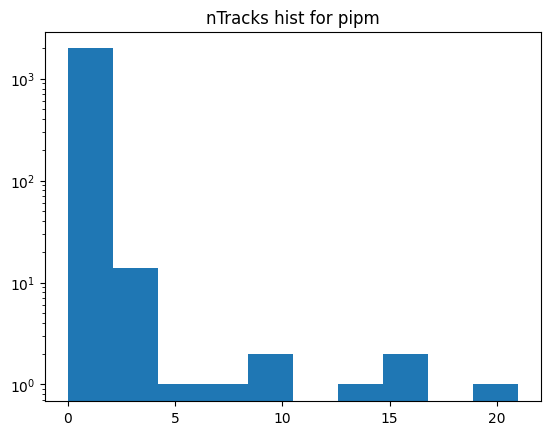

In [20]:

plt.hist(file["nTrack"].array())
plt.title("nTracks hist for pipm")
plt.yscale('log')

In [8]:
events["nTrack"].array()

<Array [1, 1, 1, 1, 1, 0, 1, 1, ..., 1, 1, 1, 0, 1, 1, 1] type='5000 * int32'>